# Connor Hughes ME 225ML HW2
For Parts B, C, and D, please see the PDF submission. My collaborators on this assignment were Gabby Villalpando-Torres and Sasha Davydov. 

In [42]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import tensorflow as tf 
import scipy.integrate as spi
import numpy as np
import math
import matplotlib.pyplot as plt

tf.compat.v1.disable_eager_execution()
sess = tf.compat.v1.InteractiveSession()

C:\Users\conno\anaconda3\envs\ME225_ML\lib\site-packages\tensorflow\python\client\session.py:1766: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Part A:

### Simulate the ODE:

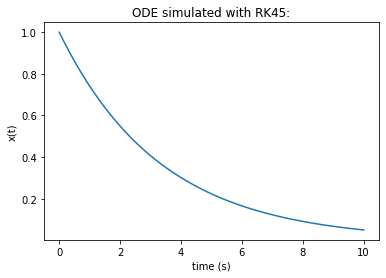

In [43]:
# Define ODE:
def dxdt(self, x):
    return -0.3*x[0]

# Initial condition:
x0 = np.array([1])
t_range = np.linspace(0, 10, 100)
t_span = (0, 10)

# Solve the ODE, simulate over desired 10s time interval:
x_traj = spi.solve_ivp(dxdt, t_span, x0, 'RK45', t_range)

plt.plot(x_traj.t, np.transpose(x_traj.y))
plt.xlabel("time (s)")
plt.ylabel("x(t)")
plt.title("ODE simulated with RK45:")
plt.show()


### Generate Training and Testing Data:
First, we will split the simulated trajectory from above into 50 data points for training and 50 for testing. The input data points and labels are both 1-dimensional. 

In [44]:
# Split the input data points into training and testing data
x_train = x_traj.t[::2]
x_train = np.asarray(x_train,dtype=np.float32)
x_train = x_train.reshape(len(x_train), 1)


y_train = np.transpose(x_traj.y)[::2]
y_train = y_train.reshape(len(y_train), 1)


x_test = x_traj.t[1:100:2]
x_test = np.asarray(x_test,dtype=np.float32)
x_test = x_test.reshape(len(x_test), 1)

y_test = np.transpose(x_traj.y)[1:100:2]
y_test = y_test.reshape(len(y_test), 1)

data_feature_dim = 1
label_feature_dim = 1

### Plot Training Data to sanity check:

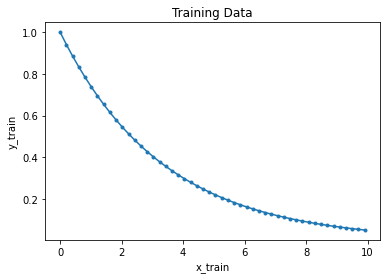

In [45]:
plt.plot(x_train, y_train, marker='.')
plt.title('Training Data')
plt.xlabel('x_train')
plt.ylabel('y_train')
plt.show()

### Define Data Hooks:

In [46]:
X = tf.compat.v1.placeholder(tf.float32,shape=[None,data_feature_dim])  
Y = tf.compat.v1.placeholder(tf.float32,shape=[None,label_feature_dim])

### Define Tensorflow Variables:
Here, we set the number of nodes in the hidden layer to 20. This value was determined by trial and error during repeated training and testing. The weights and biases are initialized using the Xavier Glorot initialization method. 

In [61]:
hidden_feature_dim = 20; 

In [62]:
w0 = tf.Variable(tf.random.truncated_normal(shape=(data_feature_dim,hidden_feature_dim),mean=np.random.rand(1,1),\
                                           stddev = math.sqrt(3.0)/(data_feature_dim*hidden_feature_dim)),dtype=np.float32) 
w1 = tf.Variable(tf.random.truncated_normal(shape=(hidden_feature_dim,label_feature_dim),mean=np.random.rand(1,1),\
                                           stddev = math.sqrt(3.0)/(data_feature_dim*label_feature_dim)),dtype=np.float32)


bvec = tf.Variable(tf.random.truncated_normal(shape=(hidden_feature_dim,1),mean=np.random.rand(1,1),\
                                           stddev = math.sqrt(3.0)/2),dtype=np.float32) 
bscalar = tf.Variable(tf.random.truncated_normal(shape=(1,1),mean=np.random.rand(1,1),\
                                           stddev = math.sqrt(3.0)),dtype=np.float32) 

### Define Neural Network Layers:
Here, we define our neural network to have only a single hidden layer, wherein each node uses a ReLU activation function. After this hidden layer, we perform another affine transformation with weights and a bias term (which are to be learned) so that we can generate a scalar output as desired. 

In [63]:
z = tf.nn.relu(tf.add(tf.matmul(X,w0),tf.transpose(bvec))) 
yhat = tf.add(tf.matmul(z, w1), bscalar)

### Define Loss Function:
Here, we use the suggested Loss Function, so that our learning algorithm minimizes the maximum 2-norm between the labels and the values estimated for each of the corresponding input data points. 

In [64]:
Loss_Function = tf.reduce_max(tf.linalg.norm((yhat)-Y))

### Initialize Variables and Train the Neural Network:
Below, we set the learning rate to 0.4, which was selected through trial-and-error during numerous training and testing processes. Additionally, we set the number of epochs to 100,000 -- a value which was chosen such that the training loss converged satisfactorily, after having identified effective choices for the number of nodes and the learning rate. 

In [65]:
show_every=1000
Learning_Rate = 0.4; 
Session_Optimizer = tf.compat.v1.train.AdagradOptimizer(Learning_Rate).minimize(Loss_Function)
result = sess.run(tf.compat.v1.global_variables_initializer())
epochs = 100000

In [66]:
for i in range(epochs):
    sess.run(Session_Optimizer,feed_dict={X:x_train,Y:y_train})
    if i % show_every ==0: 
        cur_loss_train = sess.run(Loss_Function,feed_dict={X:x_train,Y:y_train}); 
#        cur_loss_val = sess.run(Loss_Function,feed_dict={X:x_val,y:y_val}); 
        print("Training loss at Epoch # ", i , "is : ", cur_loss_train/y_train.shape[0])
#        print("Validation loss at Epoch # ", i , "is : ", cur_loss_val/y_val.shape[0])

Training loss at Epoch #  0 is :  6.81454345703125
Training loss at Epoch #  1000 is :  0.01219227910041809
Training loss at Epoch #  2000 is :  0.006530978083610535
Training loss at Epoch #  3000 is :  0.004639924764633179
Training loss at Epoch #  4000 is :  0.003719632625579834
Training loss at Epoch #  5000 is :  0.0031842872500419616
Training loss at Epoch #  6000 is :  0.0028359419107437133
Training loss at Epoch #  7000 is :  0.0025893589854240418
Training loss at Epoch #  8000 is :  0.002405630499124527
Training loss at Epoch #  9000 is :  0.0022432367503643037
Training loss at Epoch #  10000 is :  0.0021217462420463564
Training loss at Epoch #  11000 is :  0.002011801302433014
Training loss at Epoch #  12000 is :  0.001921193301677704
Training loss at Epoch #  13000 is :  0.0018420229852199555
Training loss at Epoch #  14000 is :  0.0017775264382362366
Training loss at Epoch #  15000 is :  0.001709049493074417
Training loss at Epoch #  16000 is :  0.0016449955105781555
Trainin

### Plot Fit to Training Data:
Below, we plot the input and labels from the training data on the same axes as the neural network's estimates of the labels, to visualize the performance of the network. The plot shows that the neural network does well to approximate the desired function over the training data set, as expected. 

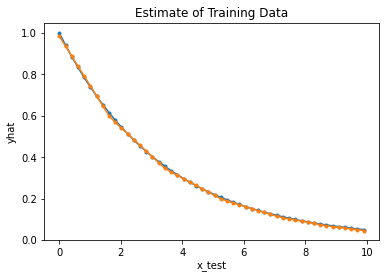

In [67]:
yhat_train = yhat.eval(feed_dict={X:x_train,Y:y_train})
plt.plot(x_train, y_train, marker='.')
plt.title('Testing Data')
plt.xlabel('x_train')
plt.ylabel('y_train')

plt.plot(x_train, yhat_train, marker='.')
plt.title('Estimate of Training Data')
plt.xlabel('x_test')
plt.ylabel('yhat')

plt.show()

### Plot Fit to Testing Data:
Below, we compute the neural network's estimates of the labels for the inputs from the testing data set, and plot these alongside the known labels for the testing data set. As shown in the plot below, the network also does well to approximate the desired function over the testing data set. 

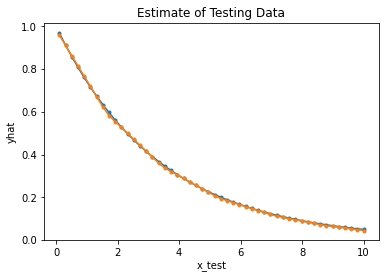

In [68]:
yhat_test = yhat.eval(feed_dict={X:x_test,Y:y_test})
plt.plot(x_test, y_test, marker='.')
plt.title('Testing Data')
plt.xlabel('x_test')
plt.ylabel('y_test')

plt.plot(x_test, yhat_test, marker='.')
plt.title('Estimate of Testing Data')
plt.xlabel('x_test')
plt.ylabel('yhat')

plt.show()

### Compute Average Loss Function over Testing Data:
Below, we evaluate the average of the 2-norm of the error between the true testing data labels and the predictions generated by the neural network. The final value is approximately 0.00368, which satisfies our performance benchmark of a maximum 2-norm error of 0.005. 

In [69]:
err = yhat_test - y_test
sq_err = np.multiply(err, err)
pwr = np.full((len(sq_err), 1), 0.5)
rtsq_err = np.power(sq_err, pwr)
TestLoss = np.mean(rtsq_err)

print(TestLoss)

0.0036846914873479154


### Examine the Learned Weights and Biases:
Below, we print out the learned weight vectors and biases which enabled the neural network to accurately approximate the desired function. 

In [70]:
w0.eval()

array([[-0.07879049, -0.10509172, -0.04424781, -0.06509826, -0.03407151,
         0.16842546, -0.16891085, -0.08701259,  0.02117357, -0.33708465,
         0.06882526,  0.13377638,  0.00232994,  0.17267834,  0.05517942,
         0.05118841, -0.03458065, -0.37818533,  0.10841689,  0.08589365]],
      dtype=float32)

In [71]:
w1.eval()

array([[ 2.0812938e-01],
       [ 1.4236367e+00],
       [ 1.4268253e+00],
       [ 2.1429482e+00],
       [-2.9077837e-01],
       [-2.5730661e-01],
       [ 2.0045754e-01],
       [ 1.6488566e+00],
       [ 2.5966363e+00],
       [ 1.7165309e-01],
       [-1.0067239e+00],
       [ 1.3535878e-01],
       [ 1.3753768e-03],
       [ 3.4606472e-02],
       [ 2.2997262e+00],
       [-4.9234916e-02],
       [ 2.5199144e+00],
       [ 2.6335305e-01],
       [ 2.6856115e-02],
       [-1.7494133e+00]], dtype=float32)

In [72]:
bvec.eval()

array([[-5.3601801e-02],
       [-7.4867558e-01],
       [-3.8137019e-02],
       [-1.0557363e+00],
       [-4.9971342e-01],
       [ 1.1868802e+00],
       [ 8.9358628e-01],
       [-3.7020725e-01],
       [-4.1343197e-01],
       [ 1.1667192e+00],
       [-8.2408446e-01],
       [-9.5189452e-01],
       [-1.9466095e-02],
       [-1.5107638e+00],
       [-6.5293813e-01],
       [ 3.0222535e-04],
       [-1.1720126e+00],
       [ 6.2455076e-01],
       [-9.2741472e-01],
       [-1.1333020e+00]], dtype=float32)

In [73]:
bscalar.eval()

array([[0.74507546]], dtype=float32)

### Conclusion:
In summary, this was another friendly introduction to the process of training a neural network. We generated training and testing data, selected an architecture for the neural network, utilized Tensorflow to train the network, and evaluated the performance after training. The most challenging aspect was simply experimenting with numerous options for the network architecture, and tuning hyperparameters including the learning rate and the number of epochs such that the desired performance was achieved. 